<a href="https://colab.research.google.com/github/dlwnsgur9242/Age-and-prediction-models/blob/main/Age_and_prediction_models_JUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leejunhyuk9242","key":"0e06082f9d1d40b0178db09fe20299e5"}'}

In [5]:
!ls -1ha kaggle.json

kaggle.json


In [6]:
!mkdir -p ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
#colab으로 utkface data 불러오기
!kaggle datasets download -d jangedoo/utkface-new

 95% 316M/331M [00:02<00:00, 96.4MB/s]
100% 331M/331M [00:02<00:00, 117MB/s] 


In [10]:
# 다운받은 폴더 압축 풀기
!unzip utkface-new.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jp

In [30]:
#https://www.kaggle.com/mohamedahmedae/utkface-v2-gender-97-race-94-age-mae-0-05 코드 참고
# 필요한 라이브러리 IMPORT
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import seaborn as sns
import plotly.graph_objects as go


# 숫자로 표현되어있는 인종, 성별 데이터를 문자열로 변환해주기 위한 dictionary 생성
dataset_dict = {
    'race_id': {
        0: 'white',
        1: 'black',
        2: 'asian',
        3: 'indian',
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

folder_name = 'UTKFace'

# 데이터 프레임으로 만들어주기 위한 함수 지정

def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()

    return df

df = parse_dataset(folder_name)

df.head()

,age,gender,race,file
0,62.0,male,black,UTKFace/62_0_1_20170113142229676.jpg.chip.jpg
1,5.0,male,black,UTKFace/5_0_1_20161219153846453.jpg.chip.jpg
2,28.0,female,white,UTKFace/28_1_0_20170108225418569.jpg.chip.jpg
3,75.0,female,white,UTKFace/75_1_0_20170110180500719.jpg.chip.jpg
4,74.0,female,white,UTKFace/74_1_0_20170120223651118.jpg.chip.jpg


In [16]:
import plotly.graph_objects as go

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()

    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)

    fig.show()

In [17]:
plot_distribution(df['race'])

In [18]:
plot_distribution(df['gender'])

In [19]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

In [20]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

In [22]:
TRAIN_TEST_SPLIT = 0.7

In [24]:
IM_WIDTH = IM_HEIGHT = 198

In [25]:
from keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    def __init__(self, df):
        self.df = df

    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])
        self.max_age = self.df['age'].max()

        return train_idx, valid_idx, test_idx

    def preprocess_image(self, img_path):
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        return im

    def generate_images(self, image_idx, is_training, batch_size=16):
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]

                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']

                im = self.preprocess_image(file)

                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)

                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []

            if not is_training:
                break

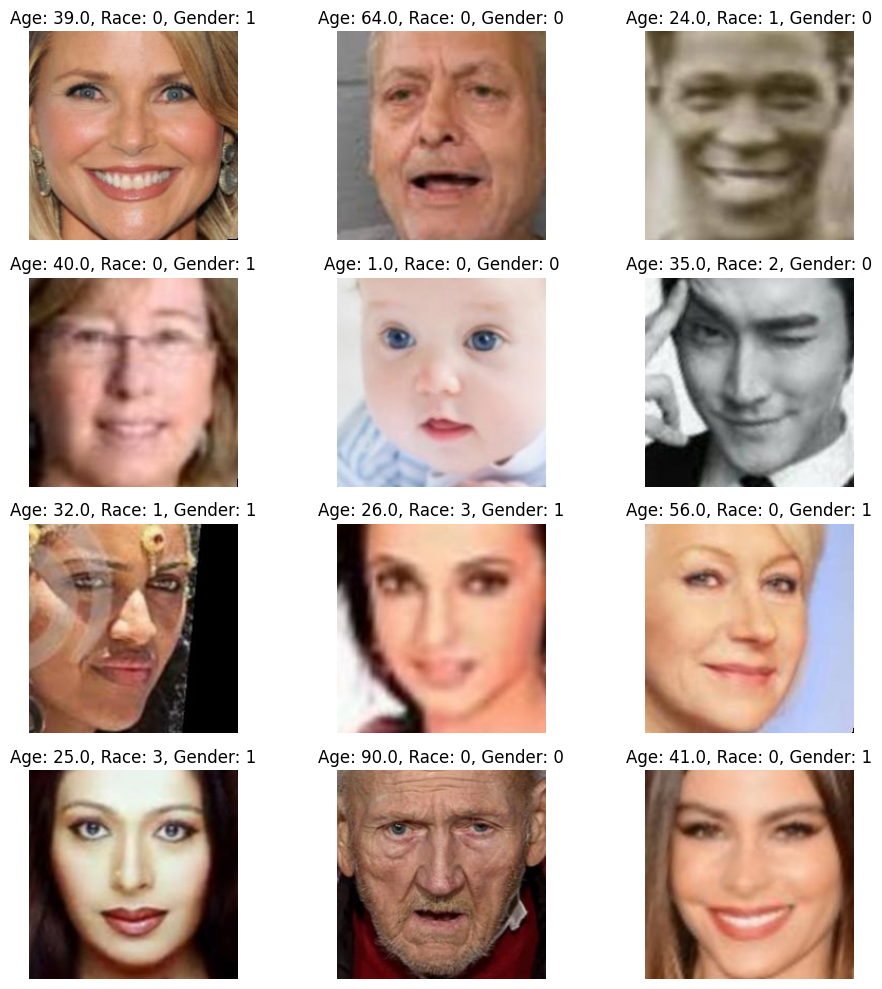

In [35]:
import matplotlib.pyplot as plt

# 데이터 제너레이터 생성
data_generator = UtkFaceDataGenerator(df)

# 학습 데이터 생성
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()
train_images, train_labels = next(data_generator.generate_images(train_idx, is_training=True, batch_size=16))

# 생성된 이미지 출력
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(train_images[i])
    plt.title(f"Age: {train_labels[0][i] * data_generator.max_age}, Race: {np.argmax(train_labels[1][i])}, Gender: {np.argmax(train_labels[2][i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

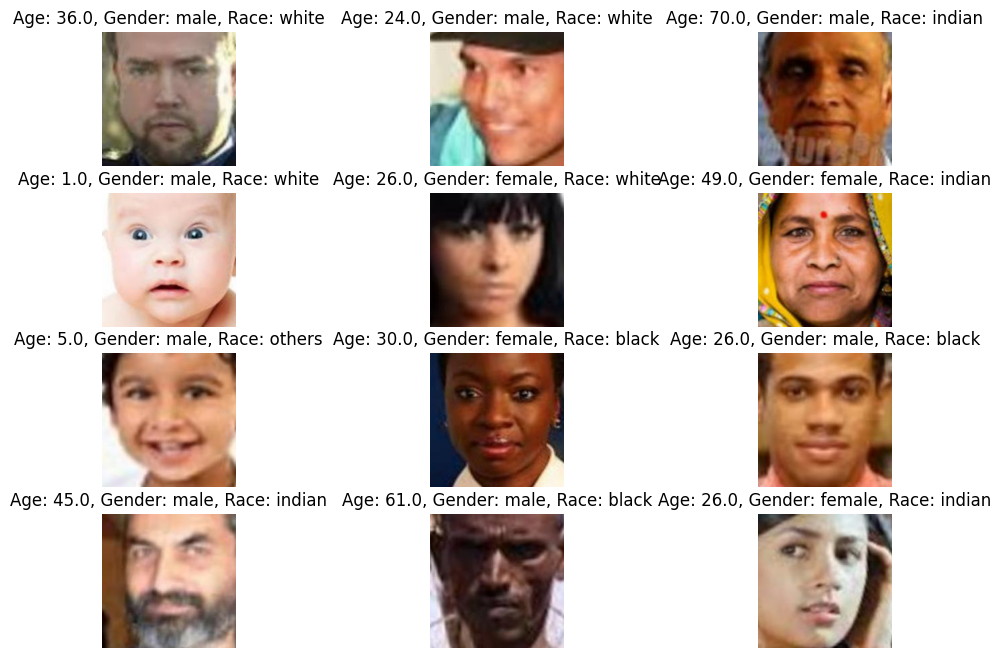

In [7]:
# 필요한 라이브러리 IMPORT
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import seaborn as sns
import plotly.graph_objects as go

# 숫자로 표현되어있는 인종, 성별 데이터를 문자열로 변환해주기 위한 dictionary 생성
dataset_dict = {
    'race_id': {
        0: 'white',
        1: 'black',
        2: 'asian',
        3: 'indian',
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

folder_name = 'UTKFace'

# 데이터 프레임으로 만들어주기 위한 함수 정의
def parse_dataset(dataset_path, ext='jpg'):
    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')
            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    return df

# UTKFace 데이터셋을 데이터 프레임으로 변환
df = parse_dataset(folder_name)

# 랜덤으로 16개 이미지 선택
random_images = df.sample(n=12)

# 선택한 이미지 출력
plt.figure(figsize=(12, 8))
for i, (index, row) in enumerate(random_images.iterrows(), start=1):
    img = cv2.imread(row['file'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 3, i)
    plt.imshow(img)
    plt.title(f"Age: {row['age']}, Gender: {row['gender']}, Race: {row['race']}")
    plt.axis('off')

plt.show()

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/
